In [3]:
# Importing Libraries

from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from causalnex.discretiser.discretiser_strategy import DecisionTreeSupervisedDiscretiserMethod
from causalnex.utils.network_utils import get_markov_blanket
from causalnex.evaluation import classification_report 
from causalnex.structure.notears import from_pandas
from causalnex.plots import NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork
import joblib

import numpy as np
import seaborn as sns
import os, sys, warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from plots import Plots
plot = Plots()

2022-07-02 10:01:51,634 — FileHandler — DEBUG — Loaded successfully!
2022-07-02 10:01:51,652 — Plot — DEBUG — Loaded successfully!


In [28]:
file_handler = FileHandler()
data_feat = file_handler.read_csv("../data/features_data.csv") 
total_data_df = file_handler.read_csv("../data/cleaned_data.csv") 

2022-07-02 10:24:32,499 — FileHandler — DEBUG — file read as csv
2022-07-02 10:24:32,504 — FileHandler — DEBUG — file read as csv


#### Label Encode the string `diagnosis` column

In [29]:
# Label encode the string value: diagnosis

encoder = preprocessing.LabelEncoder()    
diagnosis = np.float64(encoder.fit_transform(data_feat['diagnosis']))

### Scale and Normalize the Data
For creating an effective casual graph model, all the numeric columns are normalized and scaled.

In [30]:
# Scale and normalize the features except our target, diagnosis

data_feat = file_handler.scale_and_normalize(data_feat[data_feat.columns.difference(['diagnosis'])])
total_data_df = file_handler.scale_and_normalize(total_data_df[total_data_df.columns.difference(['diagnosis'])]) 

In [31]:
# Bring back `diagnosis` to the dataframe

data_feat.insert(loc=0, column='diagnosis', value=diagnosis)
total_data_df.insert(loc=0, column='diagnosis', value=diagnosis)


### Create a causal graph using all training data (this will be considered as a ground truth)

We can apply now the NOTEARS algorithm to learn the structure.

In [278]:
%%time
sm = from_pandas(data_feat, tabu_parent_nodes=['diagnosis'],)


CPU times: user 25.8 s, sys: 47.6 s, total: 1min 13s
Wall time: 10.6 s


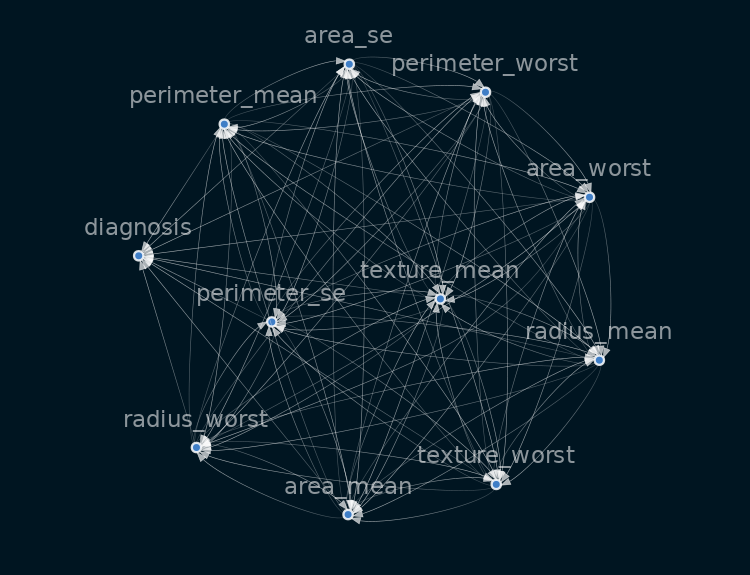

In [279]:
plot.vis_sm(sm)

Select optimal threshold that keeps the important edge connections => 0.8

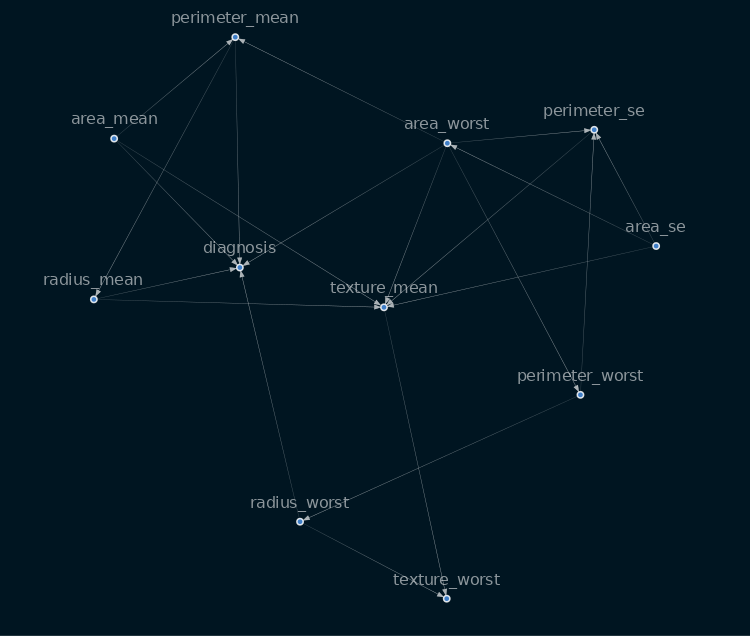

In [280]:
sm.remove_edges_below_threshold(0.80)
plot.vis_sm(sm)